<a href="https://colab.research.google.com/github/VitorPires-Unisinos/TrabalhoGB_Redes2_VitorPires/blob/main/GB_Redes_de_Computadores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Trabalho Grau B 2025/2**
## Redes de computadores: Aplicação e Transporte
## Sistema completo de transmissão digital.
## Vítor Pires

## 1. Criação da mensagem em ASCII e conversão em dados binários

In [1]:
import numpy as np

def texto_em_bits(texto):
    bits = []
    for char in texto:
        ascii_val = ord(char)  # valor ASCII do caractere
        bin_str = format(ascii_val, '08b')  # binário com 8 bits
        bits.extend([int(b) for b in bin_str])
    return np.array(bits)

def bits_em_texto(bits):
    chars = []
    for i in range(0, len(bits), 8):
        byte = bits[i:i+8]
        ascii_val = int("".join(str(b) for b in byte), 2)
        chars.append(chr(ascii_val))
    return "".join(chars)


# Exemplo de uso
mensagem = "Unisinos"
bits = texto_em_bits(mensagem)

print("Mensagem original:", mensagem)
print("Bits gerados:")
print(bits)
print("\nReconstrução (teste):", bits_em_texto(bits))

Mensagem original: Unisinos
Bits gerados:
[0 1 0 1 0 1 0 1 0 1 1 0 1 1 1 0 0 1 1 0 1 0 0 1 0 1 1 1 0 0 1 1 0 1 1 0 1
 0 0 1 0 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 0 0 1 1]

Reconstrução (teste): Unisinos


##2. Codificar de canal utilizando Manchester

In [4]:
def codificar_manchester(bits):
    manchester = []
    for b in bits:
        if b == 0:
            manchester.extend([0, 1]) # Borda de subida (Transição de Baixo para Alto)
        else:
            manchester.extend([1, 0]) # Borda de descida (Transição de Alto para Baixo)
    return np.array(manchester)

# Teste
bits_codificados = codificar_manchester(bits)

print(f"Bits originais ({len(bits)}): {bits[:10]}...")
print(f"Bits Manchester ({len(bits_codificados)}): {bits_codificados[:20]}...")

Bits originais (64): [0 1 0 1 0 1 0 1 0 1]...
Bits Manchester (128): [0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0]...


##3. Implementação das técnicas de modução digital BPSK e QPSK.

In [5]:
def modular_bpsk(bits):
    # 2*bit - 1 faz: (2*0 - 1 = -1) e (2*1 - 1 = 1)
    return (2 * bits - 1).astype(complex)

def modular_qpsk(bits):
    simbolos = []
    # Garante um número par de bits (adiciona padding se necessário)
    if len(bits) % 2 != 0:
        bits = np.append(bits, 0)

    for i in range(0, len(bits), 2):
        b1 = bits[i]
        b2 = bits[i+1]

        # Mapeamento Real (I) e Imaginário (Q)
        # 0 -> -1, 1 -> +1
        real = -1 if b1 == 0 else 1
        imag = -1 if b2 == 0 else 1

        simbolos.append(real + 1j * imag)

    return np.array(simbolos) / np.sqrt(2) # Normalização de energia

# Teste
# Modular bits previamente codificados em Manchester
sinal_bpsk = modular_bpsk(bits_codificados)
sinal_qpsk = modular_qpsk(bits_codificados)

print(f"Símbolos BPSK ({len(sinal_bpsk)}): {sinal_bpsk[:5]}")
print(f"Símbolos QPSK ({len(sinal_qpsk)}): {sinal_qpsk[:5]}")

Símbolos BPSK (128): [-1.+0.j  1.+0.j  1.+0.j -1.+0.j -1.+0.j]
Símbolos QPSK (64): [-0.70710678+0.70710678j  0.70710678-0.70710678j -0.70710678+0.70710678j
  0.70710678-0.70710678j -0.70710678+0.70710678j]


##4. Adição de ruído AWGN

In [6]:
def adicionar_ruido(sinal, snr_db):
    # Converter dB para linear
    snr_linear = 10**(snr_db/10)

    # Calcular potência do sinal e do ruído necessário
    potencia_sinal = np.mean(np.abs(sinal)**2)
    potencia_ruido = potencia_sinal / snr_linear

    # Gerar ruído complexo (parte real + imaginária)
    # Dividimos por sqrt(2) porque a potência se divide entre real e imag
    ruido = np.sqrt(potencia_ruido/2) * (np.random.randn(len(sinal)) + 1j * np.random.randn(len(sinal)))

    return sinal + ruido

##5. Demodulação e Diagrama de Constelação

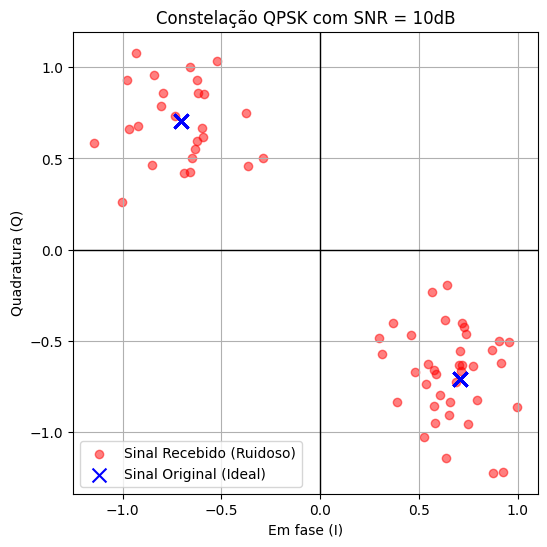

In [7]:
def demodular_bpsk(sinal_recebido):
    return (sinal_recebido.real > 0).astype(int)

def demodular_qpsk(sinal_recebido):
    bits_recuperados = []
    # Desnormalizar
    sinal = sinal_recebido * np.sqrt(2)

    for simbolo in sinal:
        # Recupera 1º bit (Eixo Real)
        b1 = 1 if simbolo.real > 0 else 0
        # Recupera 2º bit (Eixo Imaginário)
        b2 = 1 if simbolo.imag > 0 else 0
        bits_recuperados.extend([b1, b2])

    return np.array(bits_recuperados)

# Uso de ruído de 10dB (moderado)
ruido_db = 10
sinal_recebido_qpsk = adicionar_ruido(sinal_qpsk, ruido_db)

# Plotar o Diagrama de Constelação (Scatter Plot)
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.scatter(sinal_recebido_qpsk.real, sinal_recebido_qpsk.imag, c='red', alpha=0.5, label='Sinal Recebido (Ruidoso)')
plt.scatter(sinal_qpsk.real, sinal_qpsk.imag, c='blue', marker='x', s=100, label='Sinal Original (Ideal)')
plt.title(f'Constelação QPSK com SNR = {ruido_db}dB')
plt.grid(True)
plt.legend()
plt.xlabel('Em fase (I)')
plt.ylabel('Quadratura (Q)')
plt.axhline(0, color='black', lw=1)
plt.axvline(0, color='black', lw=1)
plt.show()

##6. Testes com poucos bits

Testando com 128 bits 


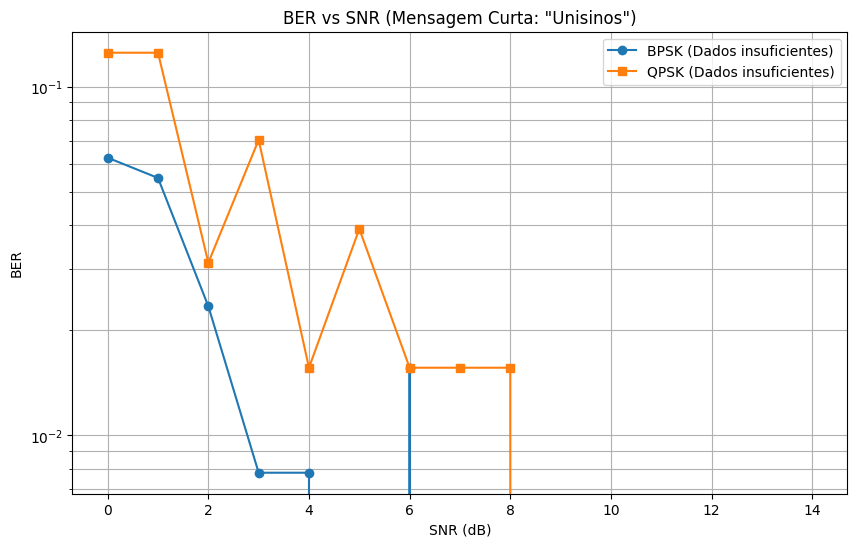

In [13]:
print(f"Testando com {len(bits_codificados)} bits ")

snr_range = range(0, 15, 1) # Teste de 0 a 14 dB (de 1 em 1)
ber_bpsk = []
ber_qpsk = []

for snr in snr_range:
    # BPSK
    # Adição de ruído ao sinal
    rx_bpsk = adicionar_ruido(sinal_bpsk, snr)
    bits_rx_bpsk = demodular_bpsk(rx_bpsk)
    erros_bpsk = np.sum(bits_codificados != bits_rx_bpsk)
    ber_bpsk.append(erros_bpsk / len(bits_codificados))

    # QPSK
    rx_qpsk = adicionar_ruido(sinal_qpsk, snr)
    bits_rx_qpsk = demodular_qpsk(rx_qpsk)
    bits_rx_qpsk = bits_rx_qpsk[:len(bits_codificados)] # Garantia de tamanho
    erros_qpsk = np.sum(bits_codificados != bits_rx_qpsk)
    ber_qpsk.append(erros_qpsk / len(bits_codificados))

# Plotagem
plt.figure(figsize=(10, 6))
plt.semilogy(snr_range, ber_bpsk, 'o-', label='BPSK (Dados insuficientes)')
plt.semilogy(snr_range, ber_qpsk, 's-', label='QPSK (Dados insuficientes)')
plt.title('BER vs SNR (Mensagem Curta: "Unisinos")')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.grid(True, which="both", ls="-")
plt.legend()
plt.show()

Testando com apenas 336 bits (Mensagem curta)...


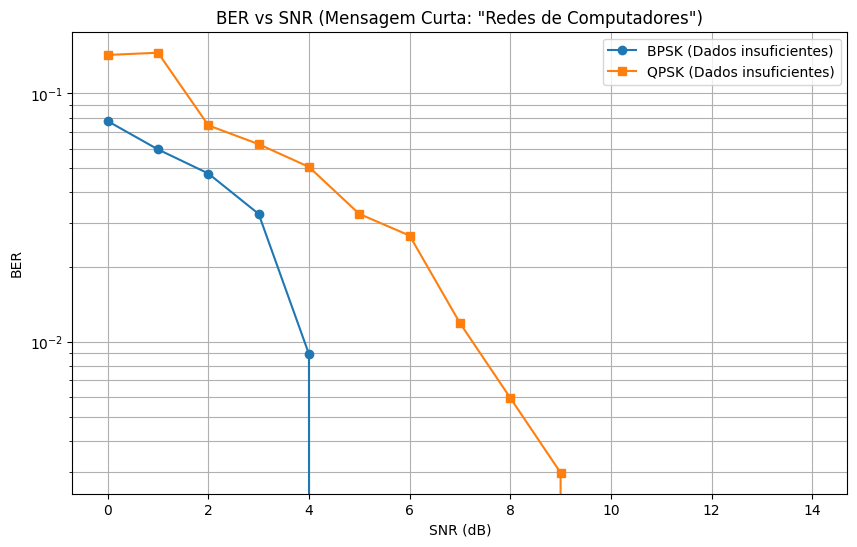

In [ ]:
print(f"Testando com {len(bits_codificados)} bits ")

snr_range = range(0, 15, 1) # Teste de 0 a 14 dB (de 1 em 1)
ber_bpsk = []
ber_qpsk = []

for snr in snr_range:
    # BPSK
    # Adição de ruído ao sinal
    rx_bpsk = adicionar_ruido(sinal_bpsk, snr)
    bits_rx_bpsk = demodular_bpsk(rx_bpsk)
    erros_bpsk = np.sum(bits_codificados != bits_rx_bpsk)
    ber_bpsk.append(erros_bpsk / len(bits_codificados))

    # QPSK
    rx_qpsk = adicionar_ruido(sinal_qpsk, snr)
    bits_rx_qpsk = demodular_qpsk(rx_qpsk)
    bits_rx_qpsk = bits_rx_qpsk[:len(bits_codificados)] # Garantia de tamanho
    erros_qpsk = np.sum(bits_codificados != bits_rx_qpsk)
    ber_qpsk.append(erros_qpsk / len(bits_codificados))

# Plotagem
plt.figure(figsize=(10, 6))
plt.semilogy(snr_range, ber_bpsk, 'o-', label='BPSK (Dados insuficientes)')
plt.semilogy(snr_range, ber_qpsk, 's-', label='QPSK (Dados insuficientes)')
plt.title('BER vs SNR (Mensagem Curta: "Redes de Computadores")')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.grid(True, which="both", ls="-")
plt.legend()
plt.show()

##7. Teste com muitos bits (Aleatório)

Gerando 5000 bits aleatórios para a simulação...
Simulando... (Isso pode levar alguns segundos)
SNR 00dB | BER BPSK: 0.08030 | BER QPSK: 0.16120
SNR 02dB | BER BPSK: 0.03780 | BER QPSK: 0.10810
SNR 04dB | BER BPSK: 0.01400 | BER QPSK: 0.05650
SNR 06dB | BER BPSK: 0.00170 | BER QPSK: 0.02130
SNR 08dB | BER BPSK: 0.00000 | BER QPSK: 0.00670
SNR 10dB | BER BPSK: 0.00000 | BER QPSK: 0.00070
SNR 12dB | BER BPSK: 0.00000 | BER QPSK: 0.00000
SNR 14dB | BER BPSK: 0.00000 | BER QPSK: 0.00000


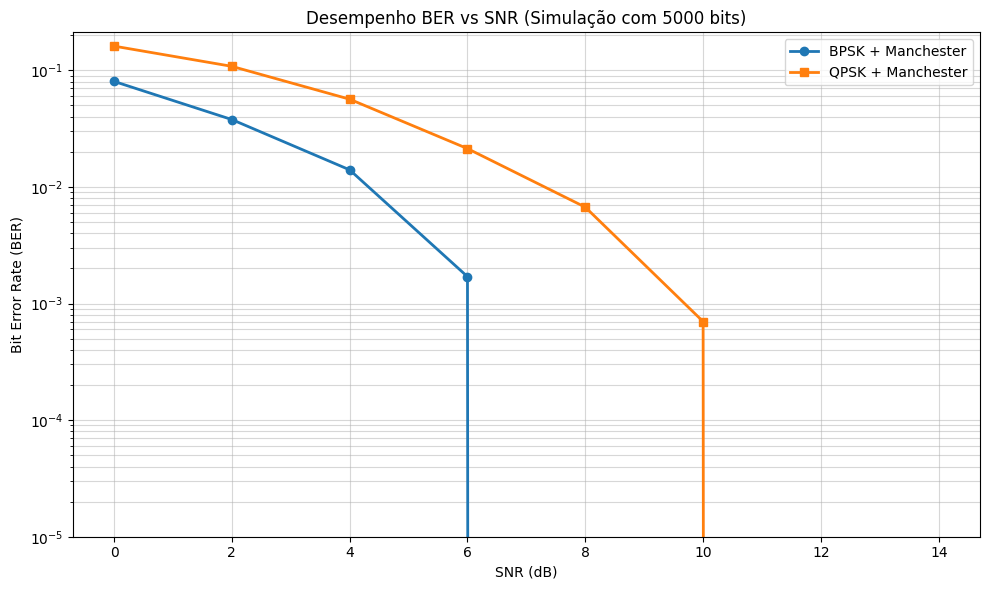

In [17]:
N_BITS = 5000
print(f"Gerando {N_BITS} bits aleatórios para a simulação...")

# Geração dos Dados (Aleatórios)
bits_originais = np.random.randint(0, 2, N_BITS)

# Codificação de Canal (Manchester)
bits_cod = codificar_manchester(bits_originais)

# Modulação
tx_bpsk = modular_bpsk(bits_cod)
tx_qpsk = modular_qpsk(bits_cod)

# Loop de SNR
snr_range = range(0, 15, 2) # 0, 2, 4 ... 14 dB
ber_bpsk = []
ber_qpsk = []

print("Simulando... (Isso pode levar alguns segundos)")

for snr in snr_range:
    # BPSK
    rx_bpsk = adicionar_ruido(tx_bpsk, snr)
    bits_rx_bpsk = demodular_bpsk(rx_bpsk)
    erros_bpsk = np.sum(bits_cod != bits_rx_bpsk)
    ber_bpsk.append(erros_bpsk / len(bits_cod))

    # QPSK
    rx_qpsk = adicionar_ruido(tx_qpsk, snr)
    bits_rx_qpsk = demodular_qpsk(rx_qpsk)
    # Garante mesmo tamanho (caso padding tenha sido adicionado)
    bits_rx_qpsk = bits_rx_qpsk[:len(bits_cod)]
    erros_qpsk = np.sum(bits_cod != bits_rx_qpsk)
    ber_qpsk.append(erros_qpsk / len(bits_cod))

    print(f"SNR {snr:02d}dB | BER BPSK: {ber_bpsk[-1]:.5f} | BER QPSK: {ber_qpsk[-1]:.5f}")

# Plotagem do Gráfico
plt.figure(figsize=(10, 6))

# Uso de 'semilogy' para escala logarítmica no eixo Y
plt.semilogy(snr_range, ber_bpsk, 'o-', linewidth=2, label='BPSK + Manchester')
plt.semilogy(snr_range, ber_qpsk, 's-', linewidth=2, label='QPSK + Manchester')

# Detalhes visuais
plt.title(f'Desempenho BER vs SNR (Simulação com {N_BITS} bits)')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend()

# Linha de referência teórica (ajuda a ver onde "zera")
plt.ylim(bottom=1e-5) # Limita o eixo Y para não ficar infinito quando o erro é 0

plt.tight_layout()
plt.show()

Gerando 10000 bits aleatórios para a simulação...
Simulando... (Isso pode levar alguns segundos)
SNR 00dB | BER BPSK: 0.07595 | BER QPSK: 0.16020
SNR 02dB | BER BPSK: 0.03805 | BER QPSK: 0.10250
SNR 04dB | BER BPSK: 0.01185 | BER QPSK: 0.05480
SNR 06dB | BER BPSK: 0.00160 | BER QPSK: 0.02150
SNR 08dB | BER BPSK: 0.00025 | BER QPSK: 0.00545
SNR 10dB | BER BPSK: 0.00005 | BER QPSK: 0.00095
SNR 12dB | BER BPSK: 0.00000 | BER QPSK: 0.00000
SNR 14dB | BER BPSK: 0.00000 | BER QPSK: 0.00000


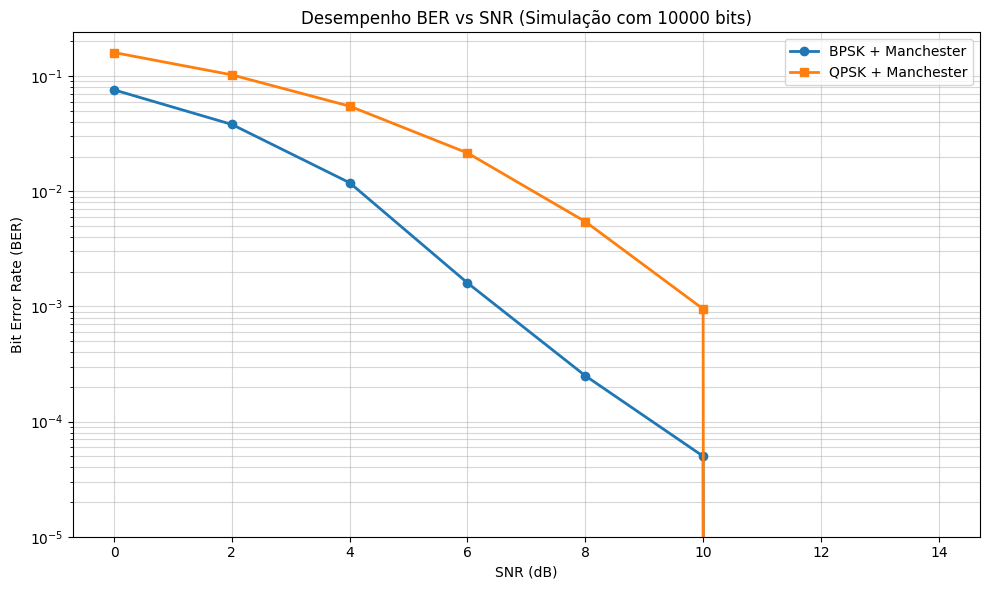

In [19]:
N_BITS = 10000
print(f"Gerando {N_BITS} bits aleatórios para a simulação...")

# Geração dos Dados (Aleatórios)
bits_originais = np.random.randint(0, 2, N_BITS)

# Codificação de Canal (Manchester)
bits_cod = codificar_manchester(bits_originais)

# Modulação
tx_bpsk = modular_bpsk(bits_cod)
tx_qpsk = modular_qpsk(bits_cod)

# Loop de SNR
snr_range = range(0, 15, 2) # 0, 2, 4 ... 14 dB
ber_bpsk = []
ber_qpsk = []

print("Simulando... (Isso pode levar alguns segundos)")

for snr in snr_range:
    # --- BPSK ---
    rx_bpsk = adicionar_ruido(tx_bpsk, snr)
    bits_rx_bpsk = demodular_bpsk(rx_bpsk)
    erros_bpsk = np.sum(bits_cod != bits_rx_bpsk)
    ber_bpsk.append(erros_bpsk / len(bits_cod))

    # QPSK
    rx_qpsk = adicionar_ruido(tx_qpsk, snr)
    bits_rx_qpsk = demodular_qpsk(rx_qpsk)
    # Garante mesmo tamanho (caso padding tenha sido adicionado)
    bits_rx_qpsk = bits_rx_qpsk[:len(bits_cod)]
    erros_qpsk = np.sum(bits_cod != bits_rx_qpsk)
    ber_qpsk.append(erros_qpsk / len(bits_cod))

    print(f"SNR {snr:02d}dB | BER BPSK: {ber_bpsk[-1]:.5f} | BER QPSK: {ber_qpsk[-1]:.5f}")

# Plotagem do Gráfico
plt.figure(figsize=(10, 6))

# Uso de 'semilogy' para escala logarítmica no eixo Y
plt.semilogy(snr_range, ber_bpsk, 'o-', linewidth=2, label='BPSK + Manchester')
plt.semilogy(snr_range, ber_qpsk, 's-', linewidth=2, label='QPSK + Manchester')

# Detalhes visuais
plt.title(f'Desempenho BER vs SNR (Simulação com {N_BITS} bits)')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend()

# Linha de referência teórica (ajuda a ver onde "zera")
plt.ylim(bottom=1e-5) # Limita o eixo Y para não ficar infinito quando o erro é 0

plt.tight_layout()
plt.show()

Gerando 100000 bits aleatórios para a simulação final...
Simulando... (Isso pode levar alguns segundos)
SNR 00dB | BER BPSK: 0.07885 | BER QPSK: 0.15861
SNR 02dB | BER BPSK: 0.03706 | BER QPSK: 0.10411
SNR 04dB | BER BPSK: 0.01246 | BER QPSK: 0.05718
SNR 06dB | BER BPSK: 0.00247 | BER QPSK: 0.02315
SNR 08dB | BER BPSK: 0.00015 | BER QPSK: 0.00590
SNR 10dB | BER BPSK: 0.00001 | BER QPSK: 0.00069
SNR 12dB | BER BPSK: 0.00000 | BER QPSK: 0.00003
SNR 14dB | BER BPSK: 0.00000 | BER QPSK: 0.00000


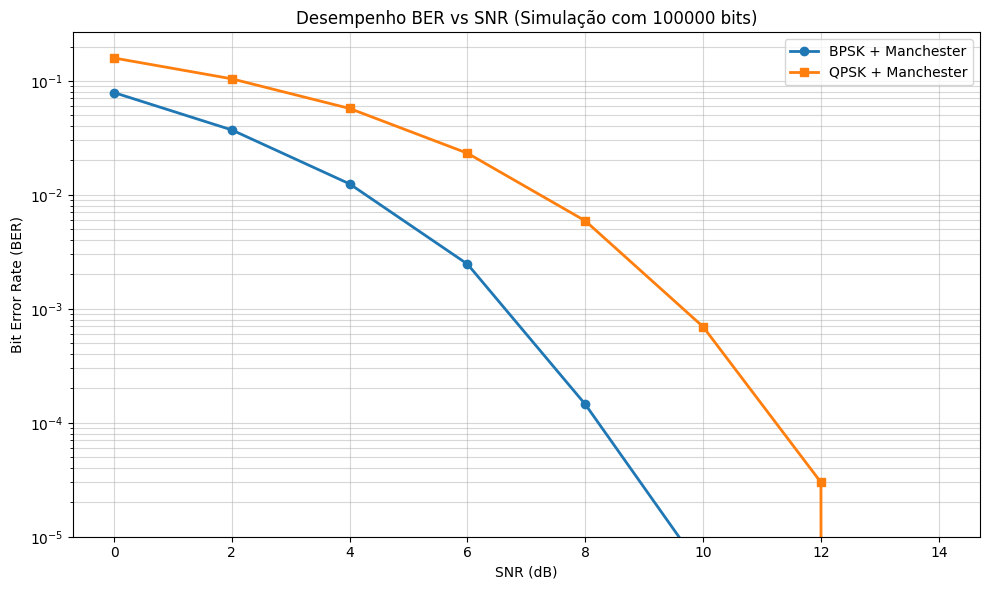

In [21]:
N_BITS = 100000
print(f"Gerando {N_BITS} bits aleatórios para a simulação final...")

# Geração dos Dados (Aleatórios)
bits_originais = np.random.randint(0, 2, N_BITS)

# Codificação de Canal (Manchester)
bits_cod = codificar_manchester(bits_originais)

# Modulação
tx_bpsk = modular_bpsk(bits_cod)
tx_qpsk = modular_qpsk(bits_cod)

# Loop de SNR
snr_range = range(0, 15, 2) # 0, 2, 4 ... 14 dB
ber_bpsk = []
ber_qpsk = []

print("Simulando... (Isso pode levar alguns segundos)")

for snr in snr_range:
    # BPSK
    rx_bpsk = adicionar_ruido(tx_bpsk, snr)
    bits_rx_bpsk = demodular_bpsk(rx_bpsk)
    erros_bpsk = np.sum(bits_cod != bits_rx_bpsk)
    ber_bpsk.append(erros_bpsk / len(bits_cod))

    #  QPSK
    rx_qpsk = adicionar_ruido(tx_qpsk, snr)
    bits_rx_qpsk = demodular_qpsk(rx_qpsk)
    # Garante mesmo tamanho (caso padding tenha sido adicionado)
    bits_rx_qpsk = bits_rx_qpsk[:len(bits_cod)]
    erros_qpsk = np.sum(bits_cod != bits_rx_qpsk)
    ber_qpsk.append(erros_qpsk / len(bits_cod))

    print(f"SNR {snr:02d}dB | BER BPSK: {ber_bpsk[-1]:.5f} | BER QPSK: {ber_qpsk[-1]:.5f}")

# Plotagem do Gráfico
plt.figure(figsize=(10, 6))

# Uso de 'semilogy' para escala logarítmica no eixo Y (Padrão de Engenharia)
plt.semilogy(snr_range, ber_bpsk, 'o-', linewidth=2, label='BPSK + Manchester')
plt.semilogy(snr_range, ber_qpsk, 's-', linewidth=2, label='QPSK + Manchester')

# Detalhes visuais
plt.title(f'Desempenho BER vs SNR (Simulação com {N_BITS} bits)')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend()

# Linha de referência teórica (ajuda a ver onde "zera")
plt.ylim(bottom=1e-5) # Limita o eixo Y para não ficar infinito quando o erro é 0

plt.tight_layout()
plt.show()